In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import models, layers, utils, optimizers, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

In [2]:
from numpy.random import seed
seed(1)

In [3]:
dataset=pd.read_csv("Data/testset.csv")
dataset

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.00,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.00,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.20,0.0,North,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99565,20161231-12:00,Partly Cloudy,15.0,0,0,NaN,77.0,NaN,1015.0,0,0,18.0,0,0,0.50,110.0,ESE,NaN,NaN,7.4
99566,20161231-13:00,Partly Cloudy,16.0,0,0,NaN,100.0,NaN,1014.0,0,0,16.0,0,0,0.80,90.0,East,NaN,NaN,3.7
99567,20161231-15:00,NaN,13.0,0,0,NaN,NaN,NaN,1016.0,0,0,NaN,0,0,0.05,10.0,North,NaN,NaN,59.3
99568,20161231-18:00,Patches of Fog,12.0,1,0,NaN,100.0,NaN,1016.0,0,0,12.0,0,0,0.50,NaN,NaN,NaN,NaN,0.0


In [4]:
dataset.columns=dataset.columns.str.replace("_","")
dataset.columns=dataset.columns.str.replace(" ","")
dataset.columns

Index(['datetimeutc', 'conds', 'dewptm', 'fog', 'hail', 'heatindexm', 'hum',
       'precipm', 'pressurem', 'rain', 'snow', 'tempm', 'thunder', 'tornado',
       'vism', 'wdird', 'wdire', 'wgustm', 'windchillm', 'wspdm'],
      dtype='object')

In [5]:
print(dataset["conds"].value_counts())

Haze                             47003
Smoke                            20551
Mist                              9104
Clear                             3129
Widespread Dust                   2830
Fog                               2656
Scattered Clouds                  2197
Partly Cloudy                     2070
Shallow Fog                       1860
Mostly Cloudy                     1520
Light Rain                        1297
Partial Fog                       1004
Patches of Fog                     850
Thunderstorms and Rain             471
Heavy Fog                          418
Light Drizzle                      410
Rain                               394
Unknown                            382
Blowing Sand                       358
Overcast                           313
Thunderstorm                       190
Light Thunderstorms and Rain       170
Drizzle                            111
Light Thunderstorm                  63
Light Fog                           56
Heavy Rain               

In [6]:
dataset["conds"]=dataset["conds"].replace(["Widespread Dust","Blowing Sand","Sandstorm", "Volcanic Ash","Light Sandstorm"],"Dust")
dataset["conds"]=dataset["conds"].replace(["Fog", "Shallow Fog", "Partial Fog","Light Fog", "Mist", "Heavy Fog", "Light Haze","Patches of Fog"],"Fog")
dataset["conds"]=dataset["conds"].replace(["Scattered Clouds", "Partly Cloudy",  "Mostly Cloudy" ,"Overcast","Funnel Cloud"], "Cloudy")
dataset["conds"]=dataset["conds"].replace(["Light Rain", "Light Drizzle","Rain", "Drizzle", "Light Rain Showers","Drizzle" ,"Rain Showers"], "Rain")
dataset["conds"]=dataset["conds"].replace(["Thunderstorms with Hail", "Squalls","Light Hail Showers" ,"Light Freezing Rain","Heavy Thunderstorms with Hail", "Unknown"], "Others")
dataset["conds"]=dataset["conds"].replace(["Thunderstorms and Rain", "Light Thunderstorms and Rain","Light Thunderstorm" ,"Heavy Thunderstorms and Rain","Heavy Rain"], "Thunderstorm")

In [7]:
print(dataset["conds"].value_counts())

Haze            47003
Smoke           20551
Fog             15952
Cloudy           6102
Dust             3200
Clear            3129
Rain             2219
Thunderstorm      942
Others            402
Name: conds, dtype: int64


In [8]:
le=LabelEncoder()
col="conds"
dataset[col]=dataset.apply(lambda x: le.fit_transform(dataset[col].astype(str)),axis=0,result_type='expand')
dataset["conds"]

0        7
1        7
2        7
3        7
4        7
        ..
99565    1
99566    1
99567    9
99568    3
99569    3
Name: conds, Length: 99570, dtype: int64

In [9]:
dataset['pressurem'].replace('-9999.0',np.nan)
dataset.replace(0,np.nan)
dataset.isnull().sum()

datetimeutc        0
conds              0
dewptm           620
fog                0
hail               0
heatindexm     70457
hum              756
precipm        99570
pressurem        232
rain               0
snow               0
tempm            672
thunder            0
tornado            0
vism            4428
wdird          14492
wdire          14492
wgustm         98507
windchillm     98997
wspdm           2358
dtype: int64

In [10]:
dataset

,datetimeutc,conds,dewptm,fog,hail,heatindexm,hum,precipm,pressurem,rain,snow,tempm,thunder,tornado,vism,wdird,wdire,wgustm,windchillm,wspdm
0,19961101-11:00,7,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.00,280.0,West,NaN,NaN,7.4
1,19961101-12:00,7,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,7,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,7,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.00,0.0,North,NaN,NaN,NaN
4,19961101-16:00,7,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.20,0.0,North,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99565,20161231-12:00,1,15.0,0,0,NaN,77.0,NaN,1015.0,0,0,18.0,0,0,0.50,110.0,ESE,NaN,NaN,7.4
99566,20161231-13:00,1,16.0,0,0,NaN,100.0,NaN,1014.0,0,0,16.0,0,0,0.80,90.0,East,NaN,NaN,3.7
99567,20161231-15:00,9,13.0,0,0,NaN,NaN,NaN,1016.0,0,0,NaN,0,0,0.05,10.0,North,NaN,NaN,59.3
99568,20161231-18:00,3,12.0,1,0,NaN,100.0,NaN,1016.0,0,0,12.0,0,0,0.50,NaN,NaN,NaN,NaN,0.0


In [11]:
hum_median=dataset["hum"].median()
dataset["hum"].fillna(hum_median,inplace=True)
pressurem_median=dataset["pressurem"].median()
dataset["pressurem"].fillna(pressurem_median,inplace=True)
wspdm_median=dataset["wspdm"].median()
dataset["wspdm"].fillna(wspdm_median,inplace=True)
tempm_median=dataset["tempm"].median()
dataset["tempm"].fillna(tempm_median,inplace=True)

In [12]:
dataset.isnull().sum()

datetimeutc        0
conds              0
dewptm           620
fog                0
hail               0
heatindexm     70457
hum                0
precipm        99570
pressurem          0
rain               0
snow               0
tempm              0
thunder            0
tornado            0
vism            4428
wdird          14492
wdire          14492
wgustm         98507
windchillm     98997
wspdm              0
dtype: int64

In [13]:
dataset

,datetimeutc,conds,dewptm,fog,hail,heatindexm,hum,precipm,pressurem,rain,snow,tempm,thunder,tornado,vism,wdird,wdire,wgustm,windchillm,wspdm
0,19961101-11:00,7,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.00,280.0,West,NaN,NaN,7.4
1,19961101-12:00,7,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,7.4
2,19961101-13:00,7,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,7.4
3,19961101-14:00,7,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.00,0.0,North,NaN,NaN,7.4
4,19961101-16:00,7,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.20,0.0,North,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99565,20161231-12:00,1,15.0,0,0,NaN,77.0,NaN,1015.0,0,0,18.0,0,0,0.50,110.0,ESE,NaN,NaN,7.4
99566,20161231-13:00,1,16.0,0,0,NaN,100.0,NaN,1014.0,0,0,16.0,0,0,0.80,90.0,East,NaN,NaN,3.7
99567,20161231-15:00,9,13.0,0,0,NaN,58.0,NaN,1016.0,0,0,27.0,0,0,0.05,10.0,North,NaN,NaN,59.3
99568,20161231-18:00,3,12.0,1,0,NaN,100.0,NaN,1016.0,0,0,12.0,0,0,0.50,NaN,NaN,NaN,NaN,0.0


In [14]:
dataset_regression=dataset[['datetimeutc','hum','tempm','pressurem','wspdm']]

In [15]:
dataset_regression

,datetimeutc,hum,tempm,pressurem,wspdm
0,19961101-11:00,27.0,30.0,1010.0,7.4
1,19961101-12:00,32.0,28.0,-9999.0,7.4
2,19961101-13:00,44.0,24.0,-9999.0,7.4
3,19961101-14:00,41.0,24.0,1010.0,7.4
4,19961101-16:00,47.0,23.0,1011.0,0.0
...,...,...,...,...,...
99565,20161231-12:00,77.0,18.0,1015.0,7.4
99566,20161231-13:00,100.0,16.0,1014.0,3.7
99567,20161231-15:00,58.0,27.0,1016.0,59.3
99568,20161231-18:00,100.0,12.0,1016.0,0.0


In [16]:
dataset_regression["datetimeutc"]=pd.to_datetime(dataset_regression["datetimeutc"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
dataset_regression.set_index("datetimeutc",inplace=True)

In [18]:
dataset_regression

,hum,tempm,pressurem,wspdm
datetimeutc,,,,
1996-11-01 11:00:00,27.0,30.0,1010.0,7.4
1996-11-01 12:00:00,32.0,28.0,-9999.0,7.4
1996-11-01 13:00:00,44.0,24.0,-9999.0,7.4
1996-11-01 14:00:00,41.0,24.0,1010.0,7.4
1996-11-01 16:00:00,47.0,23.0,1011.0,0.0
...,...,...,...,...
2016-12-31 12:00:00,77.0,18.0,1015.0,7.4
2016-12-31 13:00:00,100.0,16.0,1014.0,3.7
2016-12-31 15:00:00,58.0,27.0,1016.0,59.3


In [19]:
dataset_regression=dataset_regression.resample("D").mean()
dataset_regression

,hum,tempm,pressurem,wspdm
datetimeutc,,,,
1996-11-01,52.916667,22.333333,-2659.666667,6.166667
1996-11-02,48.625000,22.916667,1009.833333,7.950000
1996-11-03,55.958333,21.791667,1010.500000,5.020833
1996-11-04,48.055556,22.722222,1011.333333,2.266667
1996-11-05,29.400000,27.800000,1011.800000,10.020000
...,...,...,...,...
2016-12-27,67.550000,16.850000,1017.200000,8.335000
2016-12-28,68.043478,17.217391,1015.565217,3.547826
2016-12-29,87.857143,15.238095,1016.904762,6.000000


In [20]:
def extract_year(value):
  value=value.strftime('%Y-%m-%d')
  return (value[0:4])

In [21]:
def extract_month(value):
    value=value.strftime('%Y-%m-%d')
    return (value[4:6])

In [22]:
def extract_date(value):
    value=value.strftime('%Y-%m-%d')
    return (value[6:8])

In [23]:
dataset_regression.reset_index(inplace=True)

In [24]:
# dataset_regression["year"]=dataset_regression["datetimeutc"].apply(lambda x : extract_year(x))
# dataset_regression["month"]=dataset_regression["datetimeutc"].apply(lambda x : extract_month(x))
# dataset_regression["date"]=dataset_regression["datetimeutc"].apply(lambda x : extract_month(x))
dataset_regression['day'] = dataset_regression['datetimeutc'].dt.day
dataset_regression['month'] = dataset_regression['datetimeutc'].dt.month
dataset_regression['year'] = dataset_regression['datetimeutc'].dt.year

In [25]:
dataset_regression

,datetimeutc,hum,tempm,pressurem,wspdm,day,month,year
0,1996-11-01,52.916667,22.333333,-2659.666667,6.166667,1,11,1996
1,1996-11-02,48.625000,22.916667,1009.833333,7.950000,2,11,1996
2,1996-11-03,55.958333,21.791667,1010.500000,5.020833,3,11,1996
3,1996-11-04,48.055556,22.722222,1011.333333,2.266667,4,11,1996
4,1996-11-05,29.400000,27.800000,1011.800000,10.020000,5,11,1996
...,...,...,...,...,...,...,...,...
7361,2016-12-27,67.550000,16.850000,1017.200000,8.335000,27,12,2016
7362,2016-12-28,68.043478,17.217391,1015.565217,3.547826,28,12,2016
7363,2016-12-29,87.857143,15.238095,1016.904762,6.000000,29,12,2016
7364,2016-12-30,89.666667,14.095238,1017.904762,6.266667,30,12,2016


In [26]:
dataset_regression.isnull().sum()

datetimeutc      0
hum            141
tempm          141
pressurem      141
wspdm          141
day              0
month            0
year             0
dtype: int64

In [27]:
# dataset.groupby("year").tempm.mean()

In [28]:
dataset_regression.fillna(dataset_regression.mean(),inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


In [29]:
dataset_regression.isnull().sum()

datetimeutc    0
hum            0
tempm          0
pressurem      0
wspdm          0
day            0
month          0
year           0
dtype: int64

In [30]:
dataset_regression=dataset_regression.drop(["datetimeutc"],axis=1)
dataset_regression

,hum,tempm,pressurem,wspdm,day,month,year
0,52.916667,22.333333,-2659.666667,6.166667,1,11,1996
1,48.625000,22.916667,1009.833333,7.950000,2,11,1996
2,55.958333,21.791667,1010.500000,5.020833,3,11,1996
3,48.055556,22.722222,1011.333333,2.266667,4,11,1996
4,29.400000,27.800000,1011.800000,10.020000,5,11,1996
...,...,...,...,...,...,...,...
7361,67.550000,16.850000,1017.200000,8.335000,27,12,2016
7362,68.043478,17.217391,1015.565217,3.547826,28,12,2016
7363,87.857143,15.238095,1016.904762,6.000000,29,12,2016
7364,89.666667,14.095238,1017.904762,6.266667,30,12,2016


In [31]:
X_part=dataset_regression.drop(["tempm"],axis=1)
Y_part=dataset_regression["tempm"]
X_part=np.array(X_part)
Y_part=np.array(Y_part).reshape(-1,1)
print(X_part.shape)
print(Y_part.shape)

(7366, 6)
(7366, 1)


In [32]:
scaler2=MinMaxScaler(feature_range=[-1,1])
X_part_scaled=scaler2.fit_transform(X_part)
Y_part_scaled=scaler2.fit_transform(Y_part)

In [33]:
step=30
input=[]
output=[]
for i in range(len(X_part_scaled)-(step)):
    input.append(X_part_scaled[i:i+step])
    output.append(Y_part_scaled[i+step])
 
input=np.array(input)
output=np.array(output)

print(input.shape)
print(output.shape)

(7336, 30, 6)
(7336, 1)


In [34]:
trainR_X=input[:7000,::]
testR_X=input[7000:,::]
print("train_X Shape:",trainR_X.shape, ",test_X Shape:", testR_X.shape)

trainR_Y=output[:7000]
testR_Y=output[7000:]
print("test_Y Shape:",trainR_Y.shape, ",test_Y Shape:", testR_Y.shape)

train_X Shape: (7000, 30, 6) ,test_X Shape: (336, 30, 6)
test_Y Shape: (7000, 1) ,test_Y Shape: (336, 1)


In [ ]:
model2=models.Sequential()
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu", input_shape=(30,6)))
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.MaxPool1D(pool_size=2))
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.Flatten())
model2.add(layers.RepeatVector(30)) #same as input (30,1)=30
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Bidirectional(layers.LSTM(units=128, activation="relu")))
model2.add(layers.Dense(100, activation="relu"))
model2.add(layers.Dense(1))

In [ ]:
model2.compile(optimizer=optimizers.Adam(lr=0.001), loss="mae", metrics=["mse"])

In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 128)           1664      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 128)           32896     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 128)           32896     
_________________________________________________________________
flatten (Flatten)            (None, 1664)              0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 1664)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 30, 100)           7

In [ ]:
EarlyStp=callbacks.EarlyStopping(monitor="loss", mode="min", patience=5)
Savemod=callbacks.ModelCheckpoint(filepath="model2_R.h5", monitor="loss", save_best_only=True)

In [ ]:
history=model2.fit(trainR_X, trainR_Y, epochs=200,callbacks=[Savemod, EarlyStp])

Epoch 1/200
219/219 [==============================] - 56s 254ms/step - loss: 0.1428 - mse: 0.0382
Epoch 2/200
219/219 [==============================] - 56s 254ms/step - loss: 0.1134 - mse: 0.0210
Epoch 3/200
219/219 [==============================] - 56s 256ms/step - loss: 0.1077 - mse: 0.0189
Epoch 4/200
219/219 [==============================] - 56s 255ms/step - loss: 0.1025 - mse: 0.0174
Epoch 5/200
219/219 [==============================] - 57s 259ms/step - loss: 0.1024 - mse: 0.0173
Epoch 6/200
219/219 [==============================] - 56s 255ms/step - loss: 0.0993 - mse: 0.0163
Epoch 7/200
219/219 [==============================] - 55s 252ms/step - loss: 0.0948 - mse: 0.0151
Epoch 8/200
219/219 [==============================] - 56s 256ms/step - loss: 0.0944 - mse: 0.0150
Epoch 9/200
219/219 [==============================] - 60s 276ms/step - loss: 0.0917 - mse: 0.0142
Epoch 10/200
219/219 [==============================] - 56s 255ms/step - loss: 0.0905 - mse: 0.0140
Epoch 11/

In [ ]:
hist=history.history
train_loss=hist["loss"]
epoch=range(1,len(train_loss)+1)

In [ ]:
plt.plot(epoch,train_loss)

In [35]:
model=models.load_model("model2_R.h5")

In [37]:
temp_rs=model.predict(testR_X)

In [38]:
temp_rs=scaler2.inverse_transform(temp_rs)
temp_rs

array([[16.321667 ],
       [15.081567 ],
       [15.177558 ],
       [16.93416  ],
       [16.528086 ],
       [16.970251 ],
       [19.320559 ],
       [18.61237  ],
       [15.746306 ],
       [14.934986 ],
       [15.056144 ],
       [16.049574 ],
       [17.008682 ],
       [17.067894 ],
       [19.978422 ],
       [20.866457 ],
       [20.993713 ],
       [21.63617  ],
       [21.52777  ],
       [21.29236  ],
       [21.887608 ],
       [22.828064 ],
       [22.385328 ],
       [22.55579  ],
       [21.086052 ],
       [23.538862 ],
       [23.639229 ],
       [22.962734 ],
       [22.287415 ],
       [22.46008  ],
       [20.846495 ],
       [20.350195 ],
       [20.144995 ],
       [19.480143 ],
       [19.99827  ],
       [20.04559  ],
       [21.543823 ],
       [23.685955 ],
       [22.980162 ],
       [21.059525 ],
       [20.578667 ],
       [22.394999 ],
       [23.300491 ],
       [22.546324 ],
       [22.601902 ],
       [22.305927 ],
       [25.710981 ],
       [26.84

In [39]:
testR_Y_inv=scaler2.inverse_transform(testR_Y)

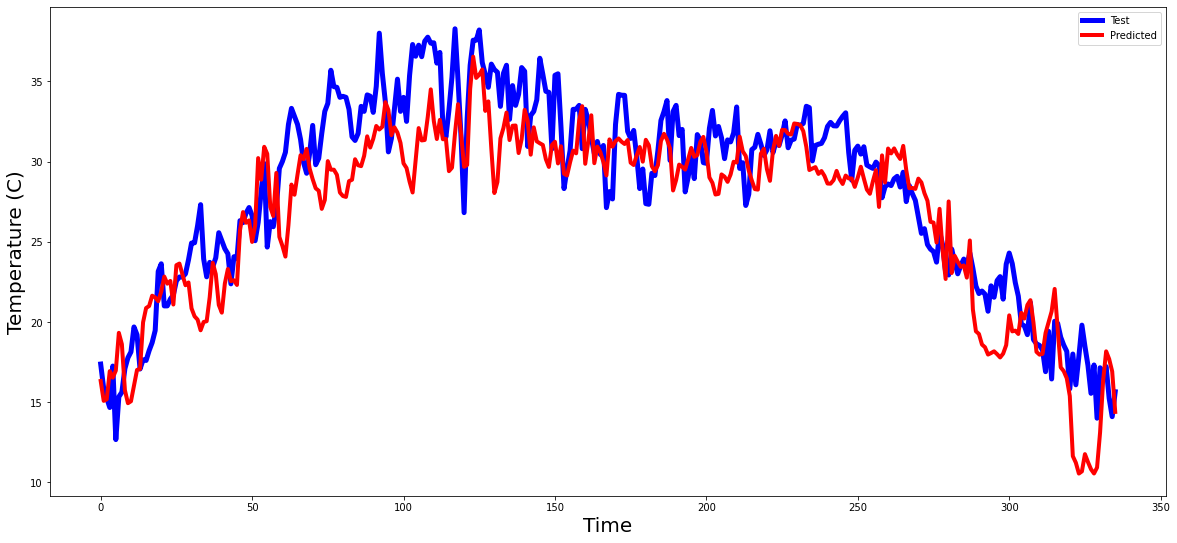

In [40]:
plt.figure(figsize=(20,9))
plt.plot(testR_Y_inv , 'blue', linewidth=5)
plt.plot(temp_rs,'r' , linewidth=4)
plt.xlabel("Time", fontsize=20)
plt.ylabel("Temperature (C)", fontsize=20)
plt.legend(('Test','Predicted'))
plt.show()

In [42]:
mse=mean_squared_error(testR_Y_inv, temp_rs,squared=False)
mae=mean_absolute_error(testR_Y_inv, temp_rs)
print("Mean Squared Error:", str(mse), "and Mean Absolute Error:", str(mae))

Mean Squared Error: 3.0753706750819534 and Mean Absolute Error: 2.458738442255406


In [44]:
test=pd.read_csv("DailyDelhiClimateTest.csv")
test

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [45]:
test.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [58]:
test["date"]=pd.to_datetime(test["date"])
test.set_index("date",inplace=True)
test

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,998.625000
2017-04-21,34.250000,39.375000,6.962500,999.875000
2017-04-22,32.900000,40.900000,8.890000,1001.600000


In [59]:
def extract_year(value):
  value=value.strftime('%Y-%m-%d')
  return (value[0:4])

In [60]:
def extract_month(value):
    value=value.strftime('%Y-%m-%d')
    return (value[4:6])

In [61]:
def extract_date(value):
    value=value.strftime('%Y-%m-%d')
    return (value[6:8])

In [62]:
test.reset_index(inplace=True)

In [63]:
test['day'] = test['date'].dt.day
test['month'] = test['date'].dt.month
test['year'] = test['date'].dt.year

In [64]:
test
temp=test.drop(["wind_speed"],axis=1)
temp=temp.append(test["wind_speed"])
# temp

In [65]:
test=test.drop(["date"],axis=1)
test

,meantemp,humidity,wind_speed,meanpressure,day,month,year
0,15.913043,85.869565,2.743478,59.000000,1,1,2017
1,18.500000,77.222222,2.894444,1018.277778,2,1,2017
2,17.111111,81.888889,4.016667,1018.333333,3,1,2017
3,18.700000,70.050000,4.545000,1015.700000,4,1,2017
4,18.388889,74.944444,3.300000,1014.333333,5,1,2017
...,...,...,...,...,...,...,...
109,34.500000,27.500000,5.562500,998.625000,20,4,2017
110,34.250000,39.375000,6.962500,999.875000,21,4,2017
111,32.900000,40.900000,8.890000,1001.600000,22,4,2017
112,32.875000,27.500000,9.962500,1002.125000,23,4,2017


In [66]:
X_part=test.drop(["meantemp"],axis=1)
X_part=X_part[['humidity','meanpressure','wind_speed','day','month','year']]
X_part

,humidity,meanpressure,wind_speed,day,month,year
0,85.869565,59.000000,2.743478,1,1,2017
1,77.222222,1018.277778,2.894444,2,1,2017
2,81.888889,1018.333333,4.016667,3,1,2017
3,70.050000,1015.700000,4.545000,4,1,2017
4,74.944444,1014.333333,3.300000,5,1,2017
...,...,...,...,...,...,...
109,27.500000,998.625000,5.562500,20,4,2017
110,39.375000,999.875000,6.962500,21,4,2017
111,40.900000,1001.600000,8.890000,22,4,2017
112,27.500000,1002.125000,9.962500,23,4,2017


In [67]:
Y_part=test["meantemp"]
X_part=np.array(X_part)
Y_part=np.array(Y_part).reshape(-1,1)
print(X_part.shape)
print(Y_part.shape)

(114, 6)
(114, 1)


In [68]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [69]:
scaler2=MinMaxScaler(feature_range=[-1,1])
X_part_scaled=scaler2.fit_transform(X_part)
Y_part_scaled=scaler2.fit_transform(Y_part)

In [70]:
step=30
input=[]
output=[]
for i in range(len(X_part_scaled)-(step)):
    input.append(X_part_scaled[i:i+step])
    output.append(Y_part_scaled[i+step])
 
input=np.array(input)
output=np.array(output)

print(input.shape)
print(output.shape)

(84, 30, 6)
(84, 1)


In [72]:
temp_rs=model.predict(input)

In [73]:
temp_rs=scaler2.inverse_transform(temp_rs)
temp_rs

array([[18.97319 ],
       [20.171644],
       [18.995571],
       [19.215576],
       [19.967194],
       [19.790524],
       [19.085464],
       [19.174805],
       [19.411327],
       [18.943674],
       [19.102009],
       [18.970554],
       [19.118546],
       [19.366026],
       [19.19077 ],
       [19.409092],
       [19.18638 ],
       [19.197336],
       [19.683582],
       [20.73121 ],
       [20.257313],
       [21.35652 ],
       [21.705265],
       [21.317158],
       [26.857388],
       [26.873638],
       [26.776585],
       [21.087114],
       [16.428858],
       [16.69423 ],
       [17.73611 ],
       [18.156042],
       [19.46356 ],
       [17.244621],
       [15.565108],
       [15.02988 ],
       [14.547262],
       [15.047916],
       [15.523956],
       [15.695711],
       [15.902888],
       [16.079716],
       [16.142323],
       [16.086203],
       [16.223791],
       [16.198984],
       [16.244404],
       [17.58188 ],
       [18.118587],
       [21.057007],


In [75]:
Y_test_inv=scaler.inverse_transform(Y_test)

In [81]:
from sklearn import metrics
mse=mean_squared_error(Y_test_inv,temp_rs,squared=False)
mae=mean_absolute_error(Y_test_inv,temp_rs)
print(f'{mse} {mae} {metrics.r2_score(Y_test_inv,temp_rs)}')

9.786527711427844 7.97473179260954 -1.758268867576167
